<a href="https://colab.research.google.com/github/vmprakash-swaminathan/NAN-MUDHALVAN-ORACLE/blob/main/Hyperparameter_Tuning_for_Random_Forest_Training_for_Customer_Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve
import joblib
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Load and Preprocess the Data

In [ ]:
data_path = './enhanced_feature_data.csv'
df = pd.read_csv(data_path)
df.drop(['tenure_bins'], axis=1, inplace=True)

# Define the feature columns and the target column
feature_columns = [col for col in df.columns if col != 'Churn']
X = df[feature_columns]
y = df['Churn']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
categorical_params = {
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['gini', 'entropy']
}

In [ ]:
continuous_params = {
    'n_estimators': Integer(100, 1000),
    'max_depth': Integer(10, 50),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Integer(1, 4)
}

In [ ]:
default_continuous_params = {k: [100 if 'n_estimators' in k else 10] for k in continuous_params.keys()}

In [ ]:
param_grid = {**categorical_params, **default_continuous_params}

In [ ]:
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [10],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [10], 'min_samples_split': [10],
                         'n_estimators': [100]},
             verbose=2)

In [ ]:
best_categorical_params = grid_search.best_params_
print(f'Best categorical parameters: {best_categorical_params}')

Best categorical parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 100}


In [ ]:
param_space = {**continuous_params}
bayes_search = BayesSearchCV(
    estimator=RandomForestClassifier(**best_categorical_params, random_state=42),
    search_spaces=param_space,
    n_iter=50,
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42
)
bayes_search.fit(X_train, y_train)
best_params = bayes_search.best_params_
print(f'Best parameters found by Bayesian Optimization: {best_params}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [ ]:
combined_params = {**best_categorical_params, **best_params}

In [ ]:
best_model = RandomForestClassifier(**combined_params, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')
print(f'ROC AUC: {roc_auc:.2f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

Accuracy: 0.81
Precision: 0.68
Recall: 0.50
F1-Score: 0.58
ROC AUC: 0.71
Confusion Matrix:
[[948  88]
 [186 187]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.92      0.87      1036
           1       0.68      0.50      0.58       373

    accuracy                           0.81      1409
   macro avg       0.76      0.71      0.73      1409
weighted avg       0.79      0.81      0.80      1409



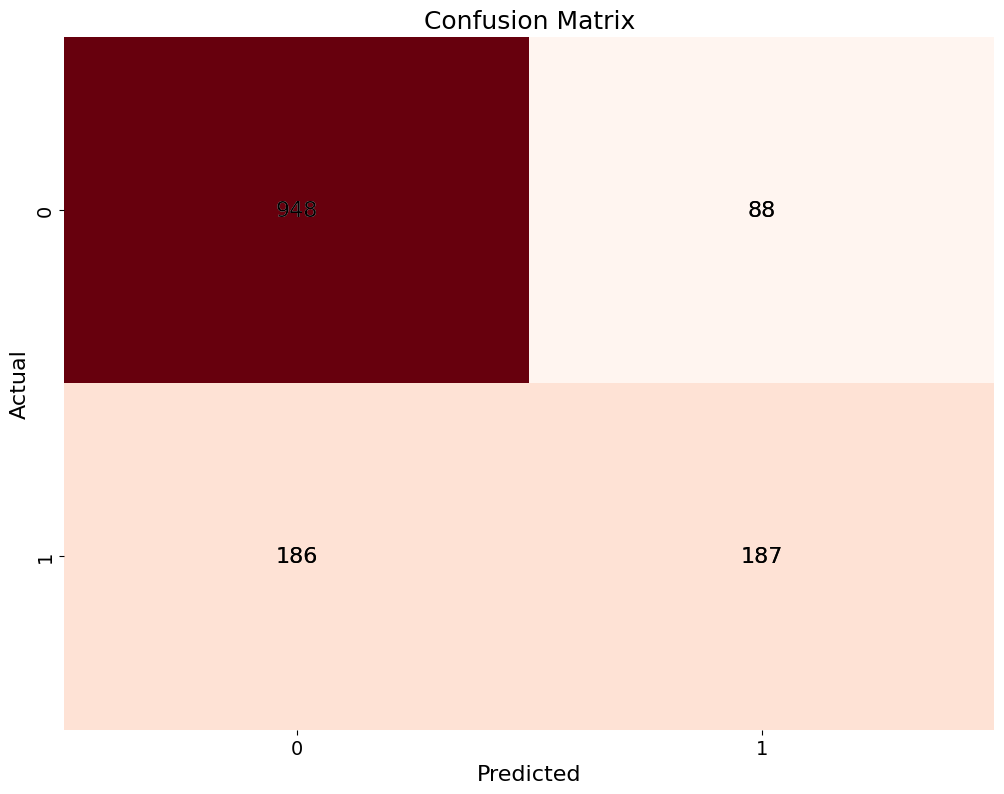

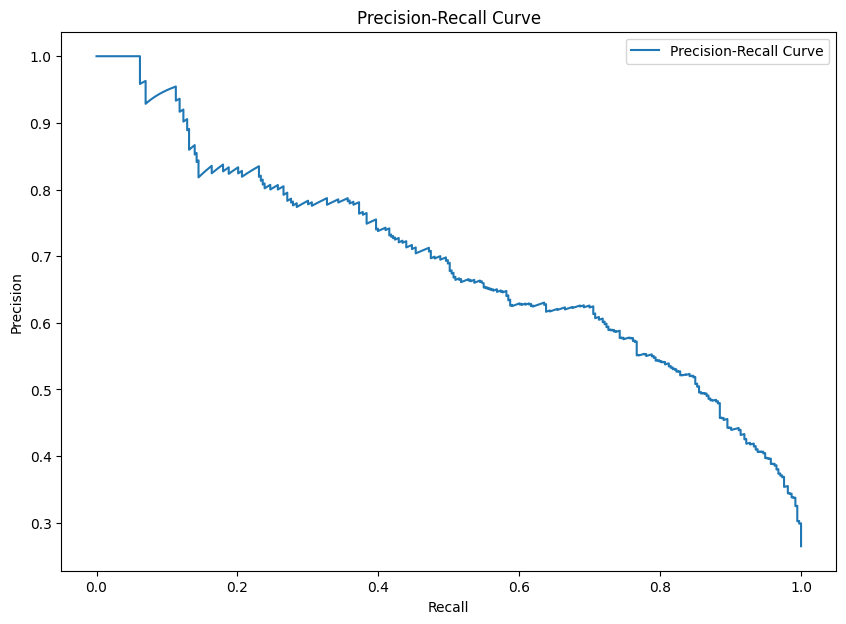

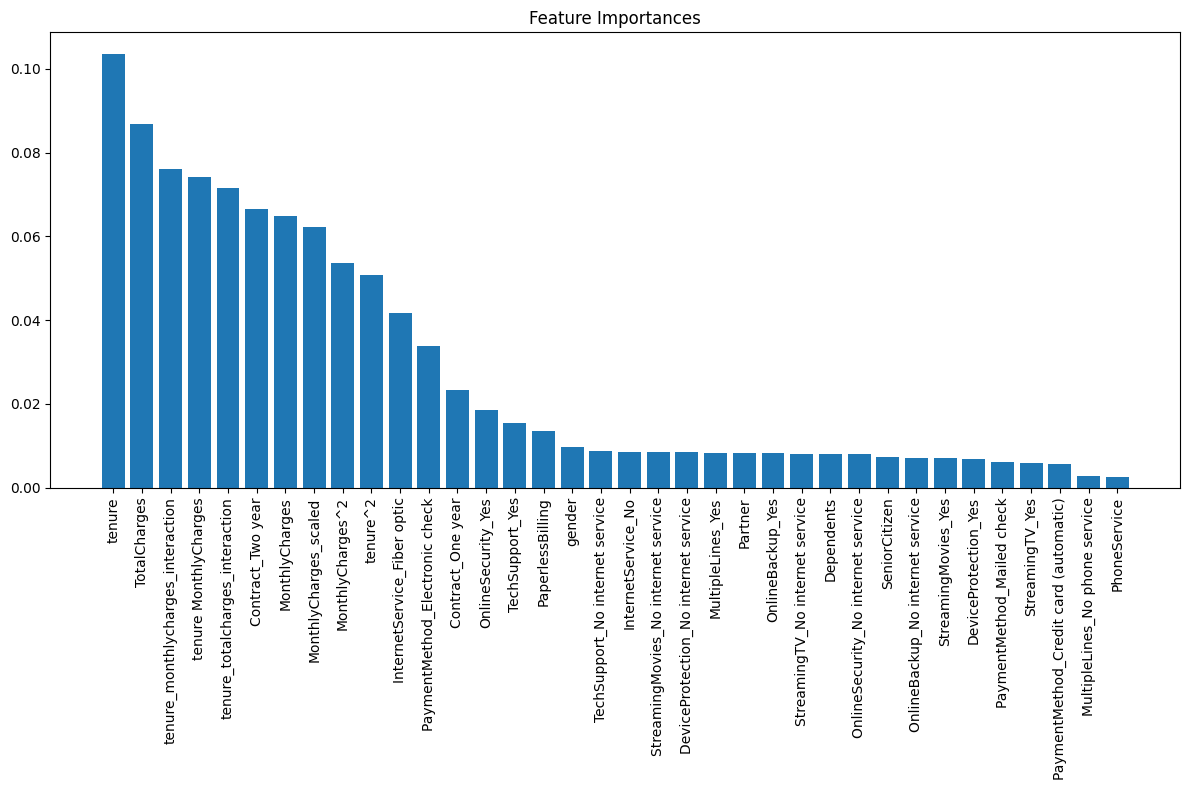

In [ ]:
plt.figure(figsize=(12, 9))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', cbar=False, annot_kws={"size": 16})
plt.title('Confusion Matrix', fontsize=18)
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('Actual', fontsize=16)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j + 0.5, i + 0.5, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center", color="black", fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

C_precision, C_recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 7))
plt.plot(C_recall, C_precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

importances = best_model.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
with open('./RandomForest_EvaluationMetrics.txt', 'w') as f:
    f.write(f'Accuracy: {accuracy:.2f}\n')
    f.write(f'Precision: {precision:.2f}\n')
    f.write(f'Recall: {recall:.2f}\n')
    f.write(f'F1-Score: {f1:.2f}\n')
    f.write(f'ROC AUC: {roc_auc:.2f}\n')

with open('./RandomForest_ClassificationReport.txt', 'w') as f:
    f.write(class_report)

plt.figure(figsize=(12, 9))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', cbar=False, annot_kws={"size": 16})
plt.title('Confusion Matrix', fontsize=18)
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('Actual', fontsize=16)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j + 0.5, i + 0.5, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center", color="black", fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('./RandomForest_ConfusionMatrix.png')
plt.close()

In [ ]:
model_filename = 'best_churn_randomforest_combined_tuning.joblib'
joblib.dump(best_model, model_filename)

print(f'Model saved to {model_filename}')

Model saved to best_churn_randomforest_combined_tuning.joblib
